In [1]:
%load_ext autoreload
%autoreload 2

import torch, click, numpy as np

import swyft
from utils import *
from plot import *

DEVICE = 'cuda'


from torch import tensor

imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')


In [44]:
m = 1
nsub = 3
nsim = 25000

nmbins = 4

lr = 1e-3
factor = 1e-1
patience = 5

system_name = "ngc4414"

In [45]:
# Set utilities
sim_name, sim_path = get_sim_path(m, nsub, nsim, system_name)
store = swyft.Store.load(path=sim_path)
print(f'Store has {len(store)} simulations.')

config = get_config(system_name, str(nsub), str(m))

prior, n_pars, lows, highs = get_prior(config)
L = config.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

dataset = swyft.Dataset(nsim, prior, store)#, simhook = noise)

Store _M_m1_nsub3_nsim25000 exists!
Loading existing store.
Store has 24938 simulations.
Image has L = 40.


In [46]:
# Load network
mre_name, mre_path = get_mre_path(sim_name, nmbins, lr, factor, patience)
print(f'Loading {mre_name}!')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    L = L,
    nmbins = nmbins, 
    lows = lows,
    highs = highs,
    marginal_classifier = CustomMarginalClassifier,
)

mre = swyft.MarginalRatioEstimator.load(
    network=network,
    device=DEVICE,
    filename=mre_path,
)

torch.set_default_tensor_type(torch.FloatTensor)

Loading UNet_M_m1_nsub3_nsim25000_nmbins4_lr-3.0_fac-1.0_pat5.pt!


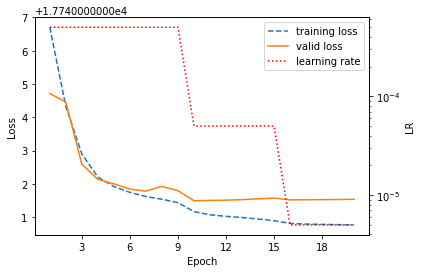

In [47]:
plot_losses(mre)

In [48]:
def get_coords(nmbins, L):
    grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    m = torch.logspace(lows[-1], highs[-1], 2*nmbins+1)
    m_centers, m_edges = m[1::2], m[0::2]
    ms = [torch.full((L*L,), m_i) for m_i in m_centers]

    coord_empty = torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)
    
    coord_full = []
    for m in ms:
        coord = torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1).reshape(1, -1).to(DEVICE, dtype = torch.float)
        coord_full.append(coord)

    coords = [coord_empty] + coord_full
    return coords, coord_empty, coord_full, m_centers, m_edges 

def get_obs(store, i = -1):
    obs0_i = np.random.randint(0, len(store)) if i == -1 else i
    print(f'i = {obs0_i}')
    
    obs0 = store[obs0_i][0]
    v0 = store[obs0_i][1]

    obs0['image'] = tensor(obs0['image']).unsqueeze(0).to(DEVICE, dtype = torch.float)
    v0 = tensor(v0).unsqueeze(0).to(DEVICE)
    
    return obs0, v0, obs0_i

coords, coord_empty, coord_full, m_centers, m_edges = get_coords(nmbins, L)

mbins = np.linspace(lows[2], highs[2], nmbins + 1)
title_mbins = [f'mass {mbins[i]} - {mbins[i+1]}' for i in range(nmbins)]
title_halos = [f'{j} {k}' for j in ['no halo', 'halo'] for k in title_mbins ]
titles = [f'{i} {j}' for i in ['target', 'ratio '] for j in title_halos ]


In [49]:
prior = nsub/(L*L)/nmbins
prior0 = 1 - prior
prior1 = prior
priors = np.repeat(np.array([prior0, prior1]), nmbins) 

print(f'prior no halo \t{prior0}\npario halo \t{prior1}')

prior no halo 	0.99953125
pario halo 	0.00046875


In [50]:
def get_pred(obs0_i = -1):
    
    # Get observation and targets
    obs0, v0, obs0_i = get_obs(store, obs0_i)
    targets = mre.network.parameter_transform(v0).squeeze()

    # Get logratios
    logratios = np.zeros((nmbins*2, L, L))
    logratios[:nmbins] = mre.network(obs0, coord_empty).view(nmbins*2, L, L)[:nmbins]
    logratios[nmbins:] = torch.stack([
        mre.network(obs0, coord).view(nmbins*2, L, L)[i+nmbins] for i, coord in enumerate(coord_full)
    ])
        
    # Posterior 
    posts = np.exp(logratios) * (priors)[:, np.newaxis, np.newaxis]
    posts_sum = np.sum(posts.reshape(2, nmbins, L, L).transpose([1,0,2,3]), axis = 1)
    posts_sum = np.tile(posts_sum, (2,1,1))
    posts_norm = posts / posts_sum
    
    # Target coordinates
    x, y = v0[0][::3].numpy(), v0[0][1::3].numpy()
    m_i = np.where(targets[nmbins:] == 1)[0]
    target_coords = np.array((m_i, x, y)).T
    
    return posts_norm[nmbins:], target_coords



## Final results

i = 4061


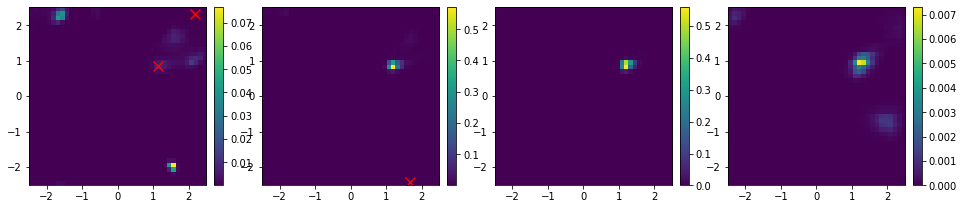

In [51]:
for _ in range(1):
    post, target_coords = get_pred()
    plt_imshow(post, target_coords = target_coords, cbar = True, **imkwargs)
#     plt_imshow(post, target_coords = target_coords, cbar = True, ylog = True, **imkwargs)

In [59]:
# create a 21 x 21 vertex mesh
xx, yy = np.meshgrid(np.linspace(0,1,21), np.linspace(0,1,21))

# create vertices for a rotated mesh (3D rotation matrix)
X =  xx 
Y =  yy
Z =  10*np.ones(X.shape)

# create some dummy data (20 x 20) for the image
data = np.cos(xx) * np.cos(xx) + np.sin(yy) * np.sin(yy)

xx.shape, X.shape, data.shape

((21, 21), (21, 21), (21, 21))

In [61]:
xx, yy = np.meshgrid(np.linspace(0,1,L), np.linspace(0,1,L))


In [253]:
m_centers

tensor([1.7783e+10, 5.6234e+10, 1.7783e+11, 5.6234e+11])

In [267]:
X =  np.tile(xx, (4,1,1)) 
Y =  np.tile(yy, (4,1,1))
Z =  np.array([m.numpy()*np.ones(X[0].shape) for m in m_centers])

In [255]:
X =  xx
Y =  yy
Z =  np.array([m.numpy()*np.ones(X.shape) for m in m_centers])

In [244]:
X.shape, Y.shape, Z.shape, post.shape

((4, 40, 40), (4, 40, 40), (4, 40, 40), (4, 40, 40))

In [270]:
len(X.flatten())

6400

In [271]:
data = np.array((X.flatten()[:2000], Y.flatten()[:2000], Z.flatten()[:2000], post.flatten()[:2000])).T

In [272]:
np.savetxt('data.txt', data)

In [195]:
# Create the 4th color-rendered dimension
scam = plt.cm.ScalarMappable(
    norm=cm.colors.Normalize(np.min(post), np.max(post))
)

In [209]:
post.shape

(4, 40, 40)

In [210]:
post_min, post_max = np.min(post), np.max(post)

1.0491565412053269e-13 0.5716187816959989


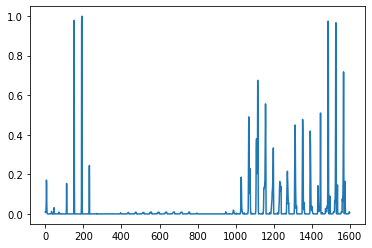

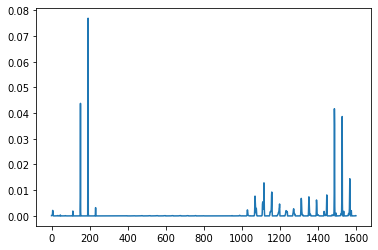

In [215]:
def get_alphas(post):
    print(post_min, post_max)
    post = ( post.flatten() - post_min ) / post_max

    a, b = 50, 1
    alphas = 1 - b * np.exp( - a * post)
    
    return alphas

plt.plot(get_alphas(post[0]))
plt.show()

plt.plot(post[0].flatten())
plt.show()

In [ ]:
mc

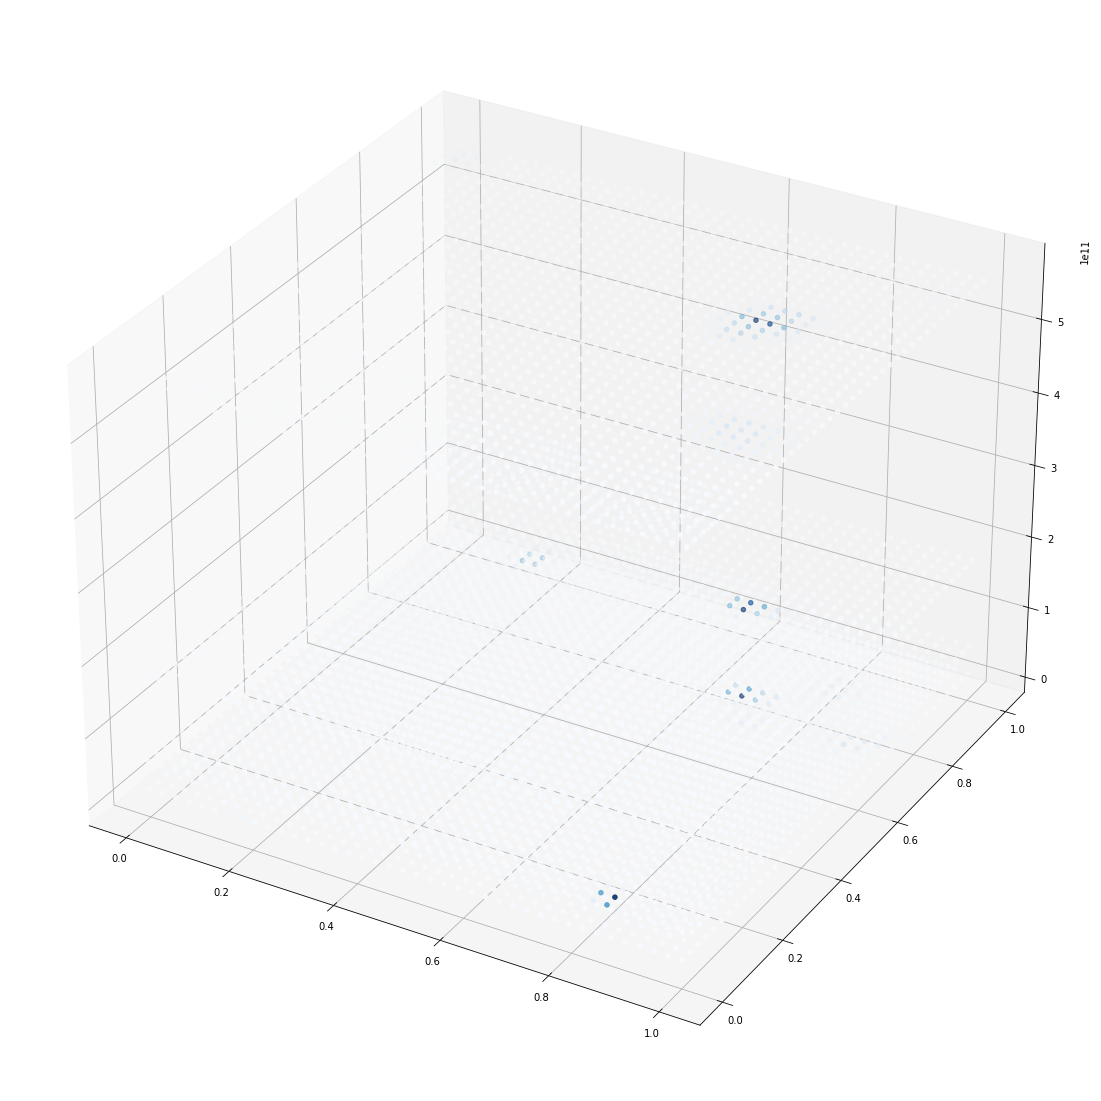

In [214]:
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(111, projection='3d')

alphas =  np.exp(- ((post[0] - post_min) / post_max)).flatten()
for i in range(nmbins):
    ax.scatter(X.flatten(), Y.flatten(), Z[i].flatten(), c = post[i].flatten(),
#              alpha = get_alphas(post[i]),
#              vmin = 0, vmax = post.max(),
               cmap = 'Blues',
              )
    
# ax.set_zscale('log')
# ax.set_zlim(10**10, 10**12)

1.0491565412053269e-13 0.5716187816959989


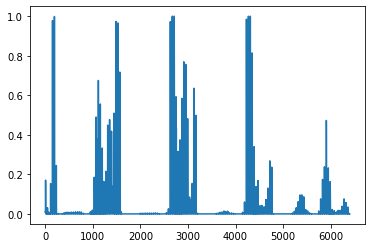

In [262]:
def get_alphas(post):
    print(post_min, post_max)
    post = ( post - post_min ) / post_max

    a, b = 50, 1
    alphas = 1 - b * np.exp( - a * post)
    
    return alphas

plt.plot(get_alphas(post).flatten())

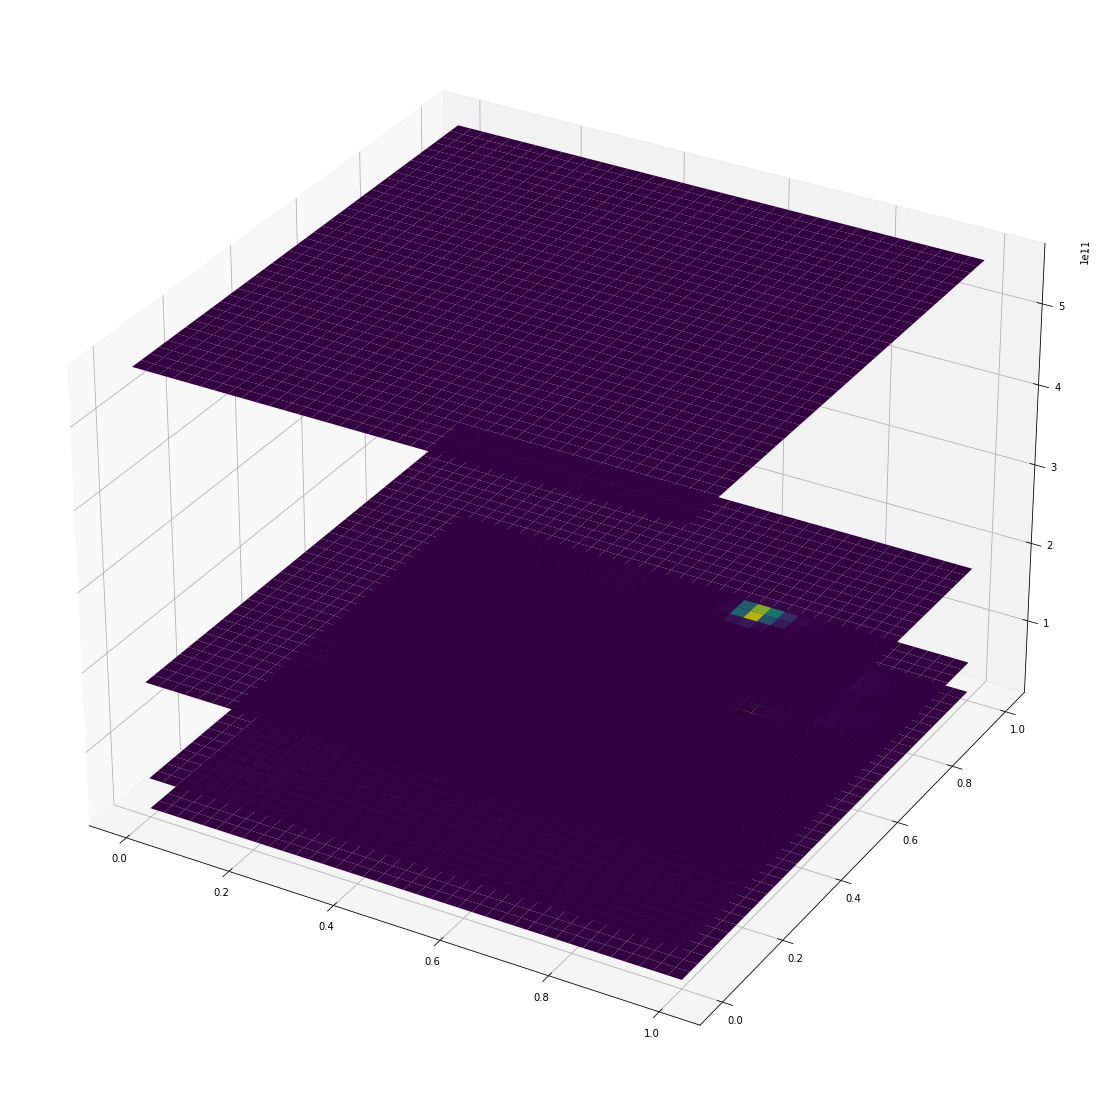

In [266]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(projection='3d')

# ax.view_init(elev=30, azim=30)

for i in range(nmbins):
    ax.plot_surface(X, Y, Z[i], facecolors = scam.to_rgba(post[i]), linewidth = 0)
    

# ax.plot_surface(xx, yy, post[1])


# ax.plot_surface(xx, yy, post[2])


# ax.plot_surface(xx, yy, post[3])



plt.show()

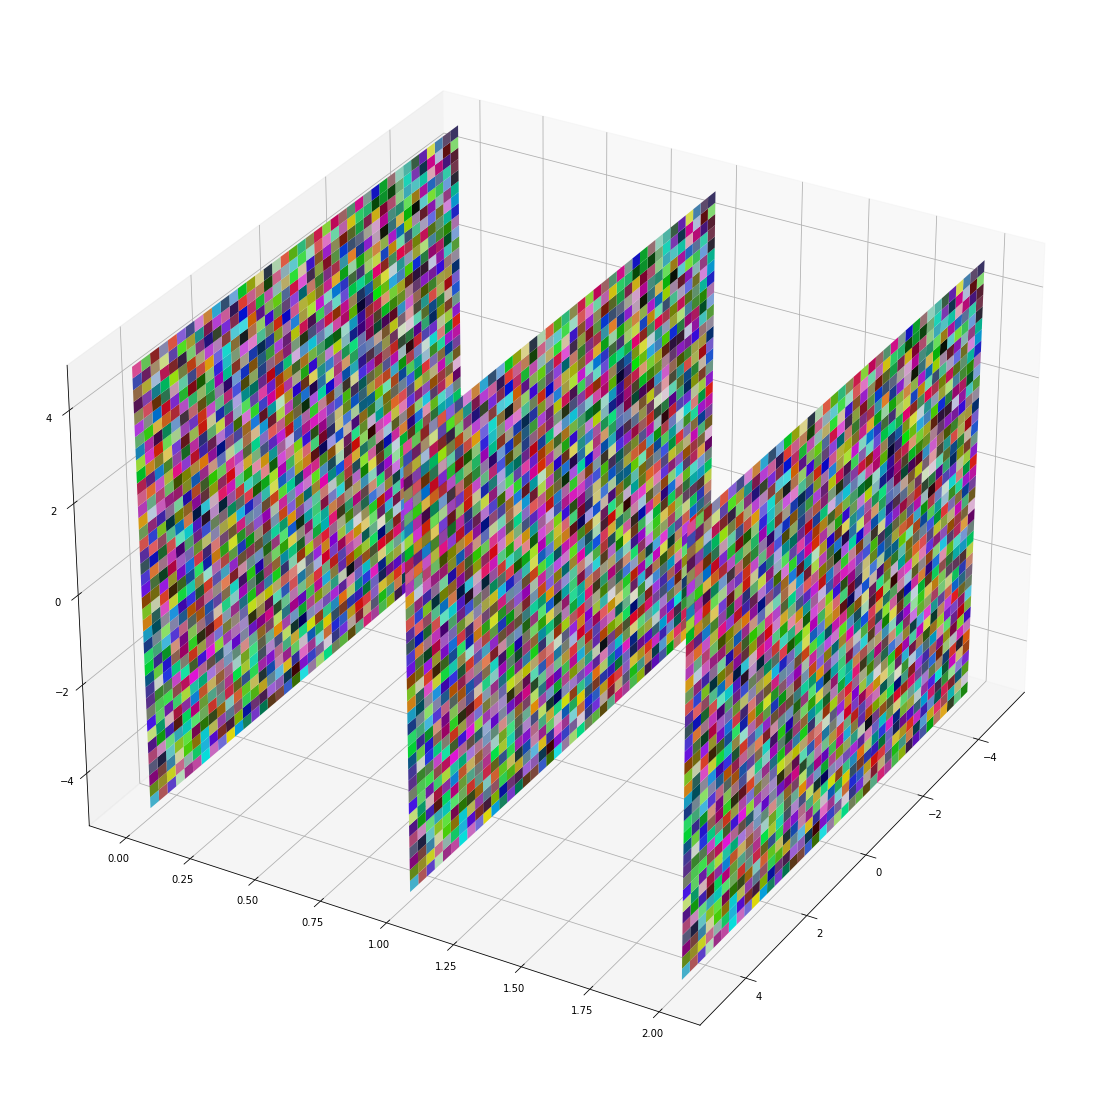

In [52]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator


fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(projection='3d')

ax.view_init(elev=30, azim=30)

X = np.arange(-5, 5, 0.25)
Z = np.arange(-5, 5, 0.25)
X, Z = np.meshgrid(X, Z)
C = np.random.random(size=40*40*3).reshape((40, 40, 3))
ax.plot_surface(X, np.ones(shape=X.shape)-1, Z, facecolors=C, linewidth=0)
ax.plot_surface(X, np.ones(shape=X.shape), Z, facecolors=C, linewidth=0)
ax.plot_surface(X, np.ones(shape=X.shape)+1, Z, facecolors=C, linewidth=0)

plt.show()

In [53]:
X.shape

(40, 40)

In [54]:
Z.shape

(40, 40)

In [278]:
colors

array([[[[1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9]],

        [[1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9]],

        [[1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9]],

        [[1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9]],

        [[1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9],
         [1. , 0. , 0. , 0.9]]],


       [[[0. , 1. , 0. , 0.9],
         [0. , 1. , 0. , 0.9],
         [0. , 1. , 0. , 0.9],
         [0. , 1. , 0. , 0.9],
         [0. , 1. , 0. , 0.9]],

        [[0. , 1. , 0. , 0.9],
         [0. , 1. , 0. , 

In [281]:
X =  xx
Y =  yy
Z =  np.array([m.numpy()*np.ones(X.shape) for m in m_centers])

In [284]:
# Plot figure
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(111, projection='3d')
  
# Voxels is used to customizations of
# the sizes, positions and colors.
ax.voxels(data, facecolors=colors, edgecolors='grey')

plt.show()

(40, 40)

In [288]:
np.indices((8, 8, 8))

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]],

        [[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         ...,
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2]],

        ...,

        [[5, 5, 5, ..., 5, 5, 5],
         [5, 5, 5, ..., 5, 5, 5],
         [5, 5, 5, ..., 5, 5, 5],
         ...,
         [5, 5, 5, ..., 5, 5, 5],
         [5, 5, 5, ..., 5, 5, 5],
         [5, 5, 5, ..., 5, 5, 5]],

        [[6, 6, 6, ..., 6, 6, 6],
         [6, 6, 6, ..., 6, 6, 6],
         [6, 6, 6, ..., 6, 6, 6],
    

In [290]:
data

array([[[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
  

In [303]:
import matplotlib as mpl
from matplotlib import cm

class MplColorHelper:

    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)

COL = MplColorHelper('viridis', post_min, post_max)
COL.get_rgb(post)


ValueError: Third dimension must be 3 or 4

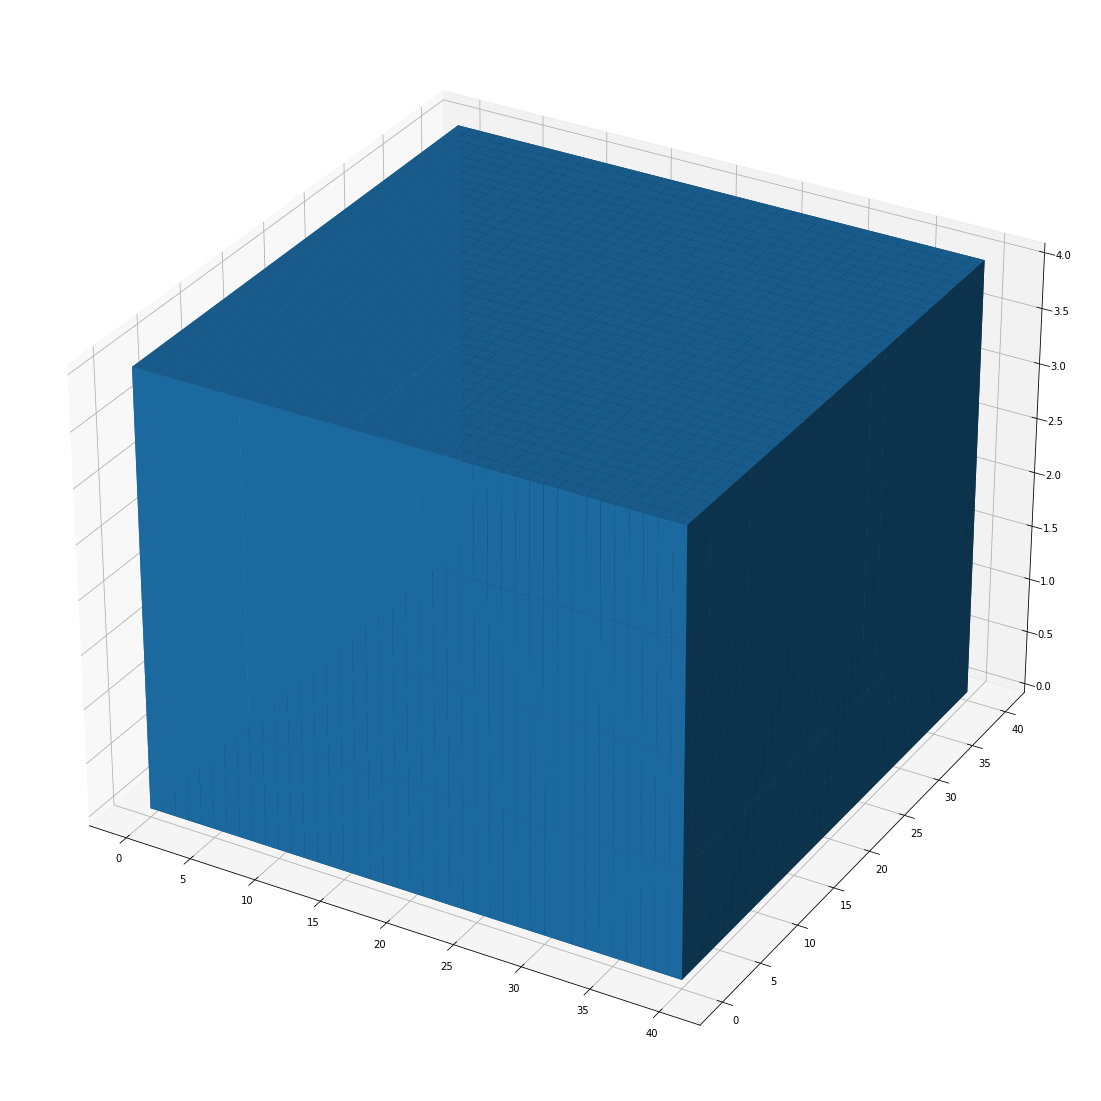

In [357]:

# Import libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

axes = [L, L, 4]
  
# Create Data
data = np.ones(axes, dtype=bool)
  
# Controll Tranperency
alpha = 0.9
  
# Control colour
colors = np.empty(data.shape, dtype=np.float32)
  
# colors[0] = [1, 0, 0, alpha]  # red
# colors[1] = [0, 1, 0, alpha]  # green
# colors[2] = [0, 0, 1, alpha]  # blue
# colors[3] = [1, 1, 0, alpha]  # yellow
# colors[4] = [1, 1, 1, alpha]  # grey
  
# Plot figure
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(111, projection='3d')
  
# Voxels is used to customizations of
# the sizes, positions and colors.
ax.voxels(data, 
#           facecolors=colors, edgecolors='grey',
         )

plt.show()

In [310]:
x.shape, y.shape, z.shape, data.shape

((9, 15, 5), (9, 15, 5), (9, 15, 5), (8, 14, 4))

In [332]:
alphas = np.random.rand(*data.shape)
alphas.shape

(8, 14, 4)

In [342]:
np.mgrid[1.2:10.5,3.4:18.3,0.3:5.8]

array([[[[ 1.2,  1.2,  1.2,  1.2,  1.2,  1.2],
         [ 1.2,  1.2,  1.2,  1.2,  1.2,  1.2],
         [ 1.2,  1.2,  1.2,  1.2,  1.2,  1.2],
         ...,
         [ 1.2,  1.2,  1.2,  1.2,  1.2,  1.2],
         [ 1.2,  1.2,  1.2,  1.2,  1.2,  1.2],
         [ 1.2,  1.2,  1.2,  1.2,  1.2,  1.2]],

        [[ 2.2,  2.2,  2.2,  2.2,  2.2,  2.2],
         [ 2.2,  2.2,  2.2,  2.2,  2.2,  2.2],
         [ 2.2,  2.2,  2.2,  2.2,  2.2,  2.2],
         ...,
         [ 2.2,  2.2,  2.2,  2.2,  2.2,  2.2],
         [ 2.2,  2.2,  2.2,  2.2,  2.2,  2.2],
         [ 2.2,  2.2,  2.2,  2.2,  2.2,  2.2]],

        [[ 3.2,  3.2,  3.2,  3.2,  3.2,  3.2],
         [ 3.2,  3.2,  3.2,  3.2,  3.2,  3.2],
         [ 3.2,  3.2,  3.2,  3.2,  3.2,  3.2],
         ...,
         [ 3.2,  3.2,  3.2,  3.2,  3.2,  3.2],
         [ 3.2,  3.2,  3.2,  3.2,  3.2,  3.2],
         [ 3.2,  3.2,  3.2,  3.2,  3.2,  3.2]],

        ...,

        [[ 8.2,  8.2,  8.2,  8.2,  8.2,  8.2],
         [ 8.2,  8.2,  8.2,  8.2,  8.2,  8.2]

In [337]:
xx

array([[0.        , 0.02564103, 0.05128205, ..., 0.94871795, 0.97435897,
        1.        ],
       [0.        , 0.02564103, 0.05128205, ..., 0.94871795, 0.97435897,
        1.        ],
       [0.        , 0.02564103, 0.05128205, ..., 0.94871795, 0.97435897,
        1.        ],
       ...,
       [0.        , 0.02564103, 0.05128205, ..., 0.94871795, 0.97435897,
        1.        ],
       [0.        , 0.02564103, 0.05128205, ..., 0.94871795, 0.97435897,
        1.        ],
       [0.        , 0.02564103, 0.05128205, ..., 0.94871795, 0.97435897,
        1.        ]])

In [348]:
# prepare some coordinates
x, y, z = np.indices((8, 8, 8))

# draw cuboids in the top left and bottom right corners, and a link between
# them
cube1 = (x < 3) & (y < 3) & (z < 3)
cube2 = (x >= 5) & (y >= 5) & (z >= 5)
link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

In [349]:
cube1

array([[[ True,  True,  True, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]],

       [[ True,  True,  True, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        

In [347]:
visiblebox

array([[[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       [[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ 

In [363]:
axes = [L, L, 4]
  
# Create Data
data = np.ones(axes, dtype=bool)

data.shape

(40, 40, 4)

In [360]:
post.shape

(4, 40, 40)

In [ ]:
x,y,z = np.mgrid[1:10,3:18,0:5]


In [367]:
xx, yy = np.meshgrid(np.linspace(0,1,L), np.linspace(0,1,L))


X =  np.tile(xx, (4,1,1)) 
Y =  np.tile(yy, (4,1,1))
Z =  np.array([m.numpy()*np.ones(X[0].shape) for m in m_centers])

In [368]:
X.shape, x.shape

((4, 40, 40), (9, 15, 5))

In [375]:
np.full_like(post, True).shape

(4, 40, 40)

In [390]:
post.shape

(4, 40, 40)

In [389]:
Z.shape

(5, 41, 41)

In [396]:
X.shape, Y.shape, Z.shape, post.shape, visible_box.shape

((4, 41, 41), (4, 41, 41), (5, 41, 41), (4, 40, 40), (4, 40, 40))

In [496]:
data.shape

(40, 40, 4)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (4,41,41)  and requested shape (5,41,41)

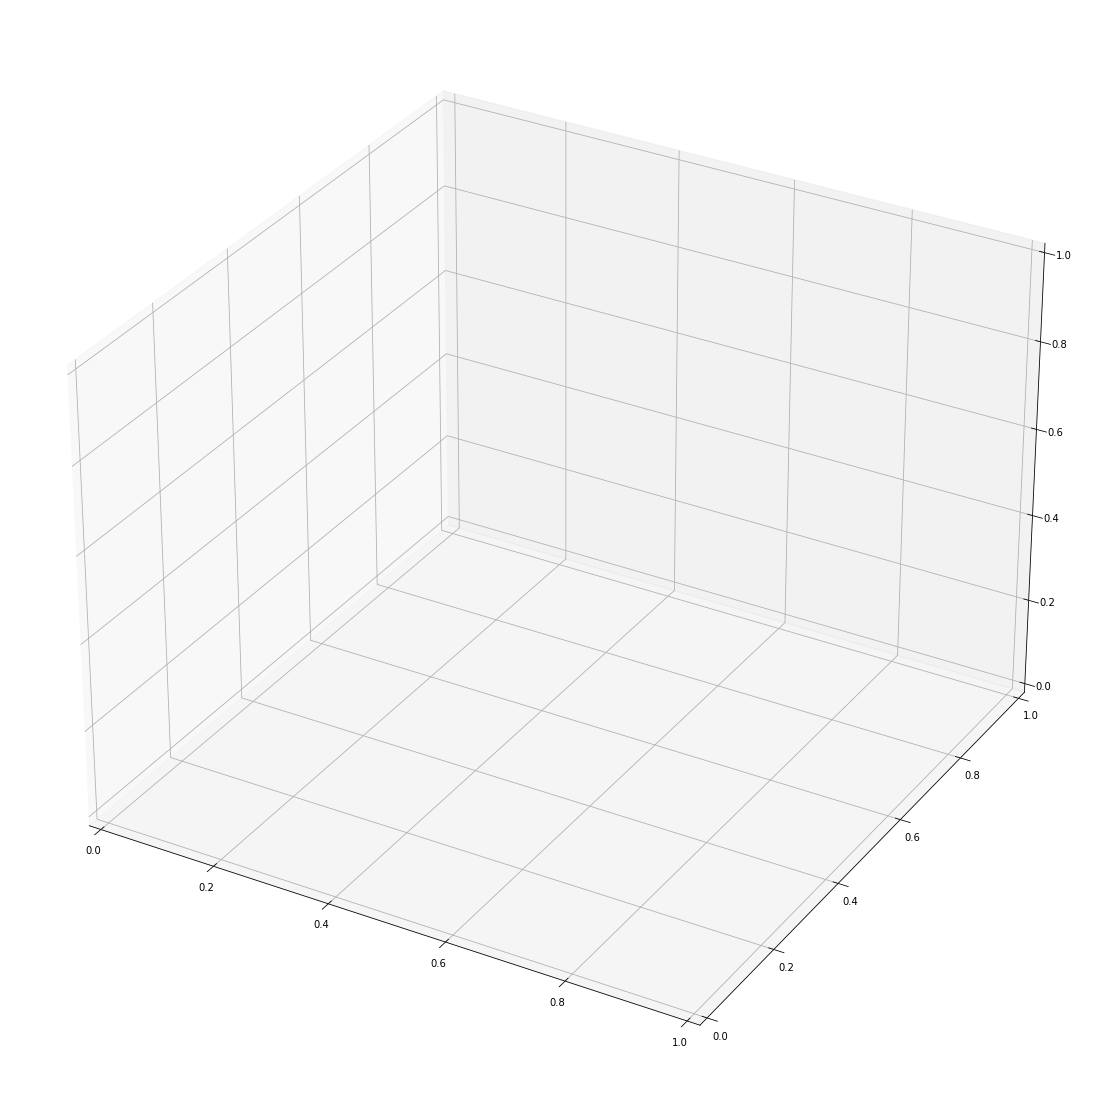

In [498]:
xx, yy = np.meshgrid(np.linspace(0,1,L+1), np.linspace(0,1,L+1))


X =  np.tile(xx, (4,1,1)) 
Y =  np.tile(yy, (4,1,1))
Z =  np.array([m.numpy()*np.ones(X[0].shape) for m in m_centers])

ax = plt.figure(figsize = (20, 20)).add_subplot(111,projection ='3d')

colors = plt.cm.plasma(post)
colors[:,:,:,-1] = np.random.rand(*post.shape)
norm = matplotlib.colors.Normalize(vmin=post_min, vmax=post_max)

visible_box = np.full_like(post, True)

vox = ax.voxels(X,Y,Z, filled = visible_box)#, facecolors=colors,edgecolor=None)

# m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
# m.set_array([])
# plt.colorbar(m)

# plt.xlabel('x')
# plt.xticks([0,1,2], ['a', 'c',3])

plt.show()

In [399]:
X.shape, Y.shape, Z.shape, post.shape, visible_box.shape, colors.shape

((4, 41, 41),
 (4, 41, 41),
 (4, 41, 41),
 (4, 40, 40),
 (4, 40, 40),
 (4, 40, 40, 4))

In [393]:
x.shape, y.shape, z.shape, data.shape, visiblebox.shape, colors.shape

((9, 15, 5), (9, 15, 5), (9, 15, 5), (8, 14, 4), (8, 14, 4), (8, 14, 4, 4))

In [469]:
xx, yy = np.meshgrid(np.linspace(0,1,L+1), np.linspace(0,1,L+1))


X =  np.tile(xx, (5,1,1)) 
Y =  np.tile(yy, (5,1,1))
Z =  np.array([m.numpy()*np.ones(X[0].shape) for m in m_centers])

# ax = plt.figure(figsize = (20, 20)).add_subplot(111,projection ='3d')

colors = plt.cm.plasma(post)
colors[:,:,:,-1] = np.random.rand(*post.shape)
norm = matplotlib.colors.Normalize(vmin=post_min, vmax=post_max)

visible_box = np.full_like(post, True)

vox = ax.voxels(X,Y,Z, filled = visible_box)#, facecolors=colors,edgecolor=None)

# m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
# m.set_array([])
# plt.colorbar(m)

# plt.xlabel('x')
# plt.xticks([0,1,2], ['a', 'c',3])

# plt.show()

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (4,41,41)  and requested shape (5,41,41)

In [410]:
np.mgrid[1:10,3:18,0:5].shape

(3, 9, 15, 5)

In [492]:
xx, yy = np.meshgrid(np.linspace(0,1,L+1), np.linspace(0,1,L+1))

X =  np.tile(xx, (5,1,1)).T
Y =  np.tile(yy, (5,1,1)).T
Z =  np.array([np.full((L+1, L+1), m) for m in m_edges]).T

X.shape, Y.shape, Z.shape


((41, 41, 5), (41, 41, 5), (41, 41, 5))

In [493]:
X.shape, Y.shape, Z.shape

((41, 41, 5), (41, 41, 5), (41, 41, 5))

In [436]:
x.shape, y.shape, z.shape, data.shape, visiblebox.shape, colors.shape

((41, 41, 5),
 (41, 41, 5),
 (41, 41, 5),
 (40, 40, 4),
 (40, 40, 4),
 (40, 40, 4, 4))

In [511]:
colors.shape

(4, 40, 40, 4)

In [509]:
data.shape

(40, 40, 4)

In [525]:
alpha = np.array((data - post_min)/post_max)
alpha = np.full(alpha.shape, 0.2)

In [523]:
alpha.shape

(40, 40, 4)

In [528]:
colors.shape

(40, 40, 4, 4)

In [531]:
x.shape, y.shape, z.shape, data.shape, visiblebox.shape, colors.shape

((9, 15, 5), (9, 15, 5), (9, 15, 5), (8, 14, 4), (8, 14, 4), (8, 14, 4, 4))

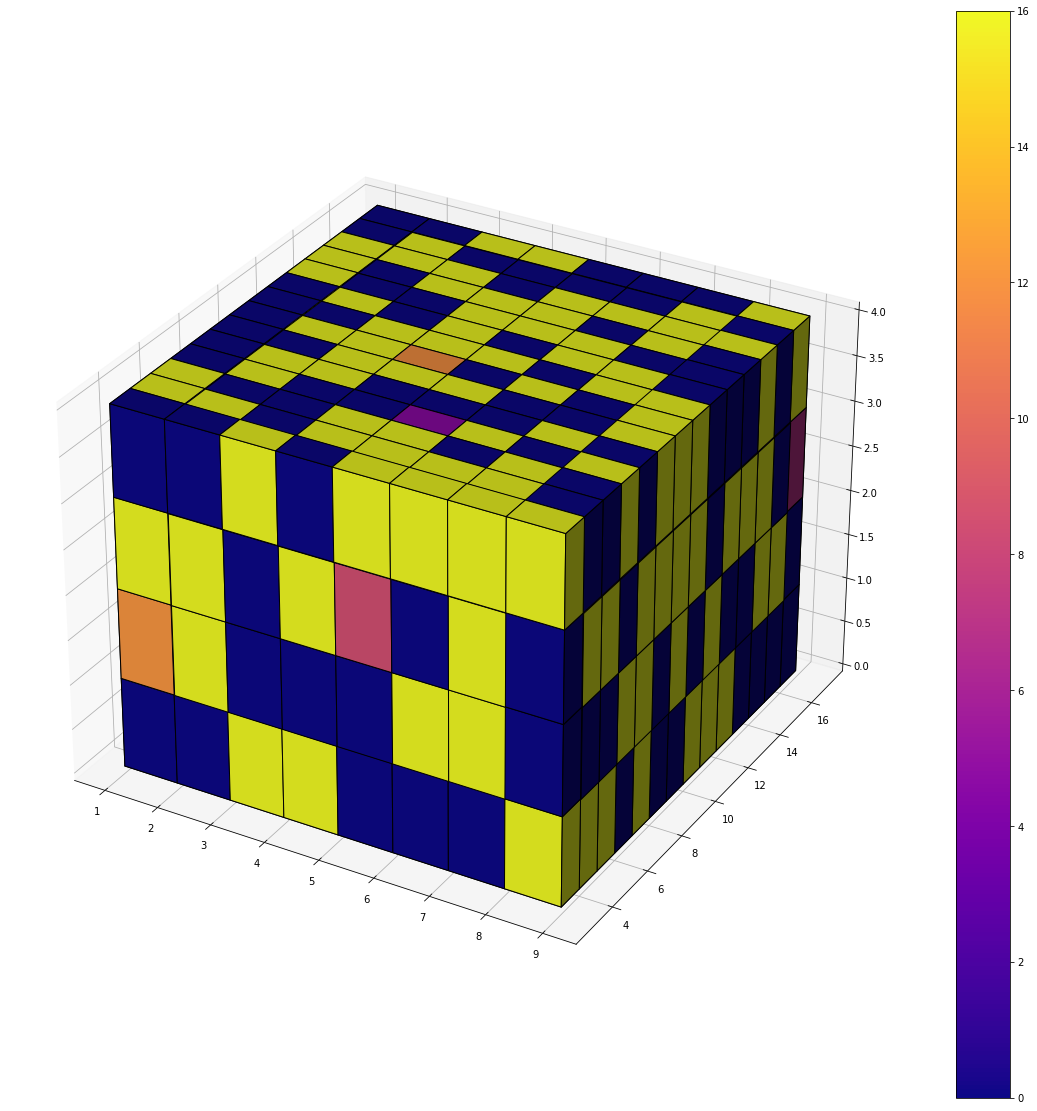

In [536]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors

x,y,z = np.mgrid[1:10,3:18,0:5]
data = np.random.normal(0,10,[x.shape[0]-1,x.shape[1]-1,x.shape[2]-1])
visiblebox = np.random.choice([True],data.shape)

ax = plt.figure(figsize = (20, 20)).add_subplot(111,projection ='3d')
colors = plt.cm.plasma(data)
norm = matplotlib.colors.Normalize(vmin=0, vmax=16)

vox = ax.voxels(x,y,z,visiblebox,facecolors=colors,edgecolor='k')

m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
m.set_array([])
plt.colorbar(m)

plt.show()

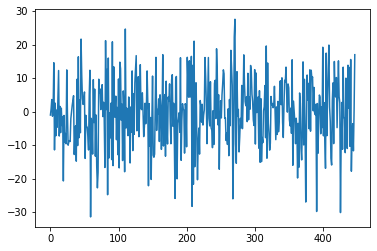

In [541]:
plt.plot( data.flatten() )

In [537]:
colors = plt.cm.plasma(data)
colors

array([[[[0.050383, 0.029803, 0.527975, 1.      ],
         [0.973416, 0.585761, 0.25154 , 1.      ],
         [0.940015, 0.975158, 0.131326, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ]],

        [[0.973416, 0.585761, 0.25154 , 1.      ],
         [0.940015, 0.975158, 0.131326, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ],
         [0.940015, 0.975158, 0.131326, 1.      ]],

        [[0.050383, 0.029803, 0.527975, 1.      ],
         [0.748289, 0.222711, 0.516834, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ],
         [0.940015, 0.975158, 0.131326, 1.      ]],

        ...,

        [[0.050383, 0.029803, 0.527975, 1.      ],
         [0.940015, 0.975158, 0.131326, 1.      ],
         [0.940015, 0.975158, 0.131326, 1.      ],
         [0.940015, 0.975158, 0.131326, 1.      ]],

        [[0.940015, 0.975158, 0.131326, 1.      ],
         [0.940015, 0.975158, 0.131326, 1.      ],
         [0.940015, 0.975158, 0.131326, 1.      ],
         

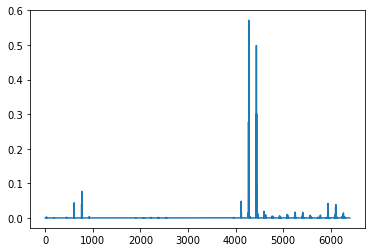

In [544]:
plt.plot( data.flatten() )

In [546]:
((data - data.mean() ) / data.std() ).shape

(40, 40, 4)

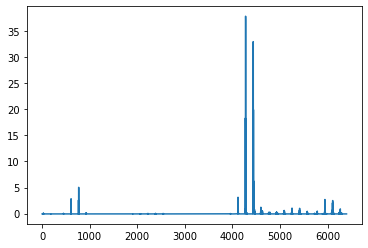

array([[[[0.050383, 0.029803, 0.527975, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ]],

        [[0.050383, 0.029803, 0.527975, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ]],

        [[0.050383, 0.029803, 0.527975, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ]],

        ...,

        [[0.050383, 0.029803, 0.527975, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ]],

        [[0.050383, 0.029803, 0.527975, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ],
         [0.050383, 0.029803, 0.527975, 1.      ],
         

In [550]:
d = ((data - data.mean() ) / data.std())

colors = plt.cm.plasma(d)

plt.plot( d.flatten())
plt.show()

colors

In [533]:
colors

array([[[[0.050383, 0.029803, 0.527975, 0.2     ],
         [0.050383, 0.029803, 0.527975, 0.2     ],
         [0.050383, 0.029803, 0.527975, 0.2     ],
         [0.050383, 0.029803, 0.527975, 0.2     ]],

        [[0.050383, 0.029803, 0.527975, 0.2     ],
         [0.050383, 0.029803, 0.527975, 0.2     ],
         [0.050383, 0.029803, 0.527975, 0.2     ],
         [0.050383, 0.029803, 0.527975, 0.2     ]],

        [[0.050383, 0.029803, 0.527975, 0.2     ],
         [0.050383, 0.029803, 0.527975, 0.2     ],
         [0.050383, 0.029803, 0.527975, 0.2     ],
         [0.050383, 0.029803, 0.527975, 0.2     ]],

        ...,

        [[0.050383, 0.029803, 0.527975, 0.2     ],
         [0.050383, 0.029803, 0.527975, 0.2     ],
         [0.050383, 0.029803, 0.527975, 0.2     ],
         [0.050383, 0.029803, 0.527975, 0.2     ]],

        [[0.050383, 0.029803, 0.527975, 0.2     ],
         [0.050383, 0.029803, 0.527975, 0.2     ],
         [0.050383, 0.029803, 0.527975, 0.2     ],
         

In [552]:
%matplotlib notebook


<IPython.core.display.Javascript object>


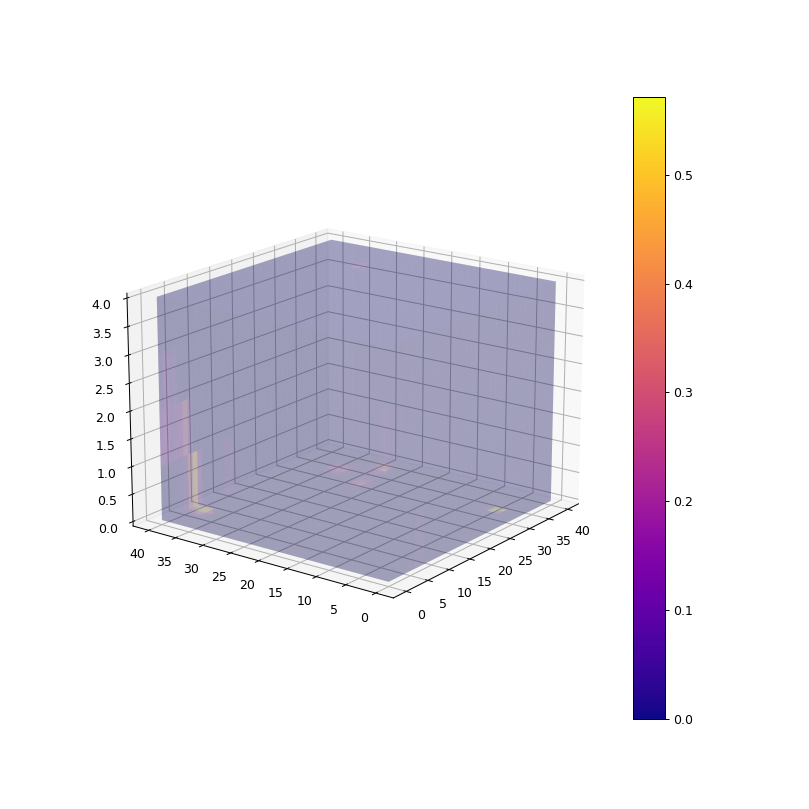

In [554]:
x,y,z = np.meshgrid(np.arange(L+1), np.arange(L+1), np.arange(4+1))

X =  np.tile(xx, (5,1,1)).T
Y =  np.tile(yy, (5,1,1)).T
Z =  np.array([np.full((L+1, L+1), m) for m in m_edges]).T


data = np.transpose(post, [1,2,0])
visiblebox = np.full_like(data, True)

ax = plt.figure(figsize = (10, 10)).add_subplot(111,projection ='3d')
d = ((data - data.mean() ) / data.std())
colors = plt.cm.plasma(d)
colors[:,:,:,-1] = alpha

norm = matplotlib.colors.Normalize(vmin=post_min, vmax = post_max)

vox = ax.voxels(x,y,z,visiblebox,facecolors=colors,edgecolor=None)

m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
m.set_array([])
plt.colorbar(m)

# plt.xlabel('x')
# plt.xticks([0,1,2], ['a', 'c',3])

plt.show()